In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
from convokit import Corpus, download

In [4]:
corpus = Corpus(filename=download('reddit-corpus-small', use_local=True))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus-small


In [5]:
corpus = corpus.reindex_conversations([utt.id for utt in corpus.iter_utterances() if utt.id == utt.meta['top_level_comment']])

In [6]:
from convokit import ThreadDetails, ThreadDynamics

In [7]:
tdetails = ThreadDetails()

In [8]:
tdetails.transform(corpus)

In [9]:
tdynamics = ThreadDynamics()

In [10]:
tdynamics.transform(corpus)

In [11]:
convo = next(corpus.iter_conversations())

In [12]:
convo.print_conversation_structure(lambda utt: utt.user.id)

EastCoastBurnerJen
    VirtualRageMaster
        PeterDarker
            William_Harzia
                VirtualRageMaster
        mrmarioman
            Cgtl
                mrmarioman
                    Cgtl
                        mrmarioman
                            Cgtl
                                mrmarioman
                                    Cgtl
                                        mrmarioman
                                            Cgtl
        arnkk
        William_Harzia
    confusedavid


In [13]:
feat_keys = sorted(convo.meta['thread_dynamics'], reverse=True)

In [14]:
import pandas as pd

In [15]:
data = []
convo_ids = []

In [16]:
for convo in corpus.iter_conversations():
    data.append([convo.meta['thread_dynamics'][k] for k in feat_keys])
    convo_ids.append(convo.id)

In [17]:
feats_df = pd.DataFrame(data, index=convo_ids, columns=feat_keys)

In [18]:
feats_df

,unique_users,C_targets_A,C_depth,C_chrono,B_depth,B_chrono,B2A_beforeC,B2A_afterC,A2B_beforeC,A2B_afterC
e6nwsyu,8,0,2,3,1,2,1,0,0,0
e60mo6r,7,0,2,3,1,2,1,0,0,0
e5d37pj,2,-1,-1,-1,1,2,4,-1,5,-1
e57zqy5,5,0,2,3,1,2,1,0,0,0
e5yl7fg,3,0,2,3,1,2,1,0,0,0
e5ur44c,5,1,1,4,1,2,1,0,1,0
e66s2rz,10,0,2,3,1,2,1,0,0,0
e5q9f8y,4,1,1,3,1,2,1,1,0,1
e5p92n0,6,0,2,3,1,2,1,0,0,0
e69g5ba,6,1,3,4,1,2,1,0,1,1


## Visualization

In [19]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [20]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feats_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
subreddits = [convo.meta['original_convo_meta']['subreddit'] for convo in corpus.iter_conversations()]

In [22]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [23]:
feats_df.shape

(10000, 10)

In [24]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feats_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_keys)

In [25]:
U_df.head()

,0,1,2,3,4,5,6
e6nwsyu,-0.492055,0.179324,-0.201706,0.462717,-0.680359,0.059784,-0.066861
e60mo6r,-0.450972,0.196968,-0.224614,0.699062,-0.378325,0.050884,-0.270129
e5d37pj,0.869501,-0.332568,0.126624,-0.065984,-0.320173,-0.004561,-0.102217
e57zqy5,-0.232748,0.153203,-0.178744,0.795367,0.192304,0.020084,-0.469484
e5yl7fg,-0.099345,0.111514,-0.132502,0.728333,0.428855,0.003045,-0.495725


In [26]:
U_df['subreddit'] = subreddits

In [27]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

In [28]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

In [29]:
import matplotlib.pyplot as plt

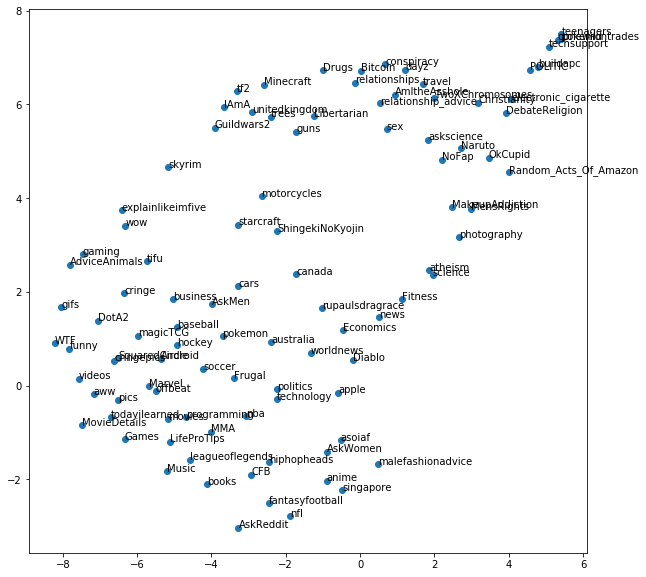

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

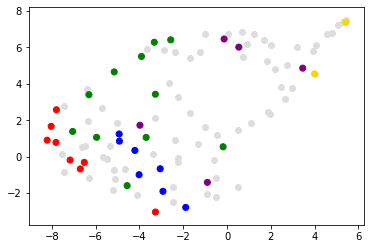

In [31]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

In [32]:
feats_df.head()

,unique_users,C_targets_A,C_depth,C_chrono,B_depth,B_chrono,B2A_beforeC,B2A_afterC,A2B_beforeC,A2B_afterC
e6nwsyu,8,0,2,3,1,2,1,0,0,0
e60mo6r,7,0,2,3,1,2,1,0,0,0
e5d37pj,2,-1,-1,-1,1,2,4,-1,5,-1
e57zqy5,5,0,2,3,1,2,1,0,0,0
e5yl7fg,3,0,2,3,1,2,1,0,0,0


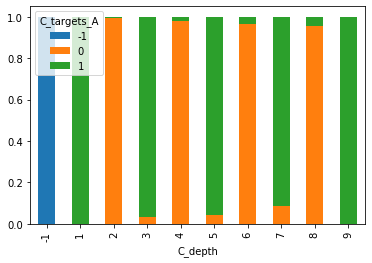

In [33]:
feats_df.groupby('C_depth')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

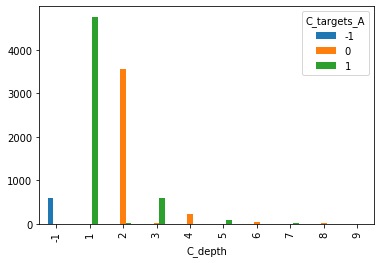

In [72]:
feats_df.groupby('C_depth')['C_targets_A'].value_counts().unstack().plot(kind='bar', stacked=False)

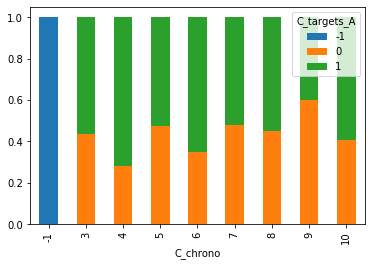

In [34]:
feats_df.groupby('C_chrono')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

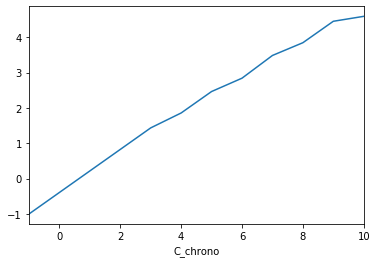

In [35]:
feats_df.groupby('C_chrono')['C_depth'].mean().plot()

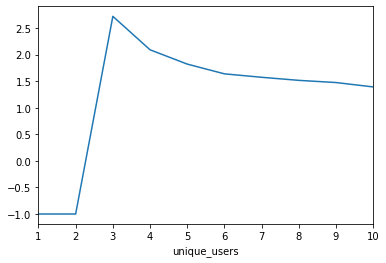

In [36]:
feats_df.groupby('unique_users')['C_depth'].mean().plot()

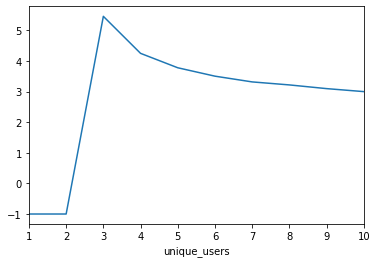

In [37]:
feats_df.groupby('unique_users')['C_chrono'].mean().plot()

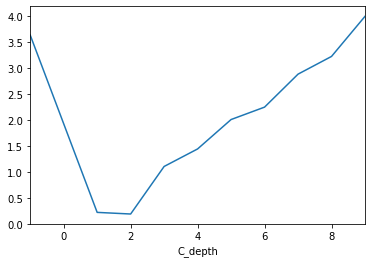

In [38]:
feats_df.groupby('C_depth')['A2B_beforeC'].mean().plot()

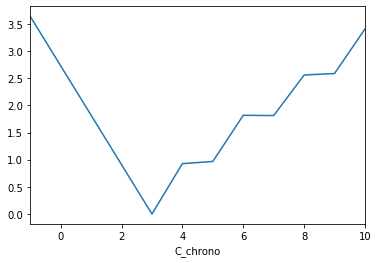

In [39]:
feats_df.groupby('C_chrono')['A2B_beforeC'].mean().plot()

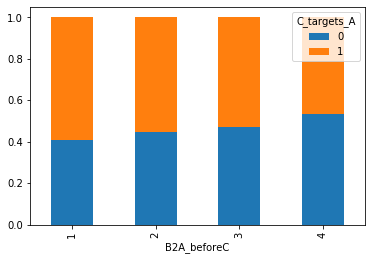

In [40]:
feats_df[feats_df['C_targets_A'] != -1].groupby('B2A_beforeC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

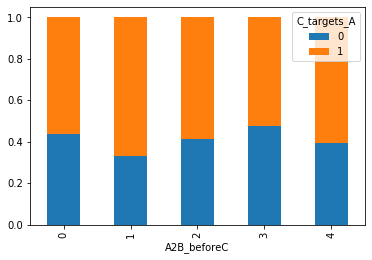

In [47]:
feats_df[feats_df['C_targets_A'] != -1].groupby('A2B_beforeC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

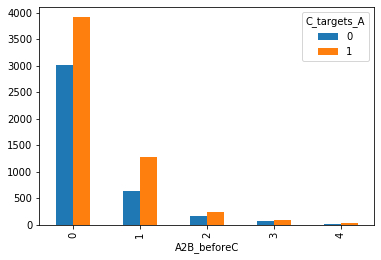

In [65]:
feats_df[feats_df['C_targets_A'] != -1].groupby('A2B_beforeC')['C_targets_A'].value_counts().unstack().plot(kind='bar')

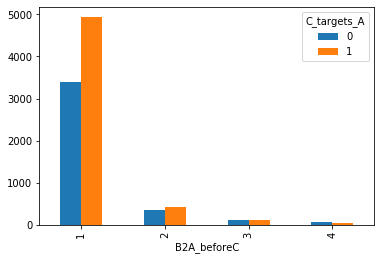

In [66]:
feats_df[feats_df['C_targets_A'] != -1].groupby('B2A_beforeC')['C_targets_A'].value_counts().unstack().plot(kind='bar')

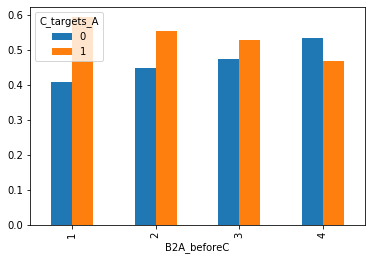

In [67]:
feats_df[feats_df['C_targets_A'] != -1].groupby('B2A_beforeC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar')

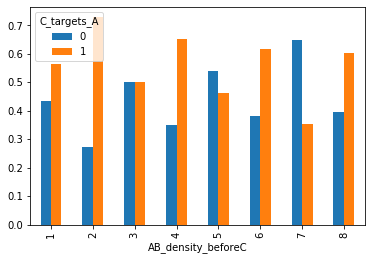

In [68]:
feats_df[feats_df['C_targets_A'] != -1].groupby('AB_density_beforeC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar')

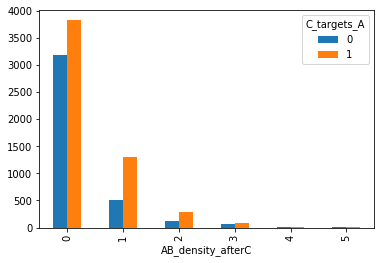

In [69]:
feats_df[feats_df['C_targets_A'] != -1].groupby('AB_density_afterC')['C_targets_A'].value_counts().unstack().plot(kind='bar')

In [44]:
feats_df['AB_density_beforeC'] = feats_df['B2A_beforeC'] + feats_df['A2B_beforeC'] 

In [46]:
feats_df['AB_density_afterC'] = feats_df['B2A_afterC'] + feats_df['A2B_afterC'] 

In [53]:
feats_df['B-A_beforeC'] = feats_df['B2A_beforeC'] - feats_df['A2B_beforeC']

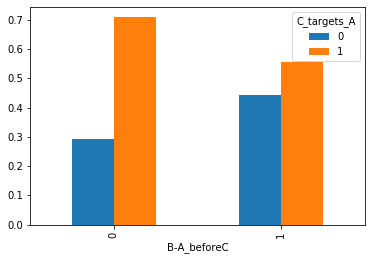

In [70]:
feats_df[feats_df['C_targets_A'] != -1].groupby('B-A_beforeC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar')

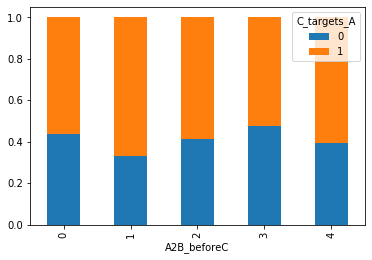

In [41]:
feats_df[feats_df['C_targets_A'] != -1].groupby('A2B_beforeC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

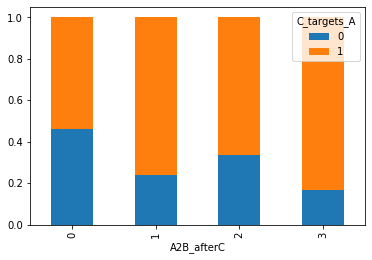

In [42]:
feats_df[feats_df['C_targets_A'] != -1].groupby('A2B_afterC')['C_targets_A'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

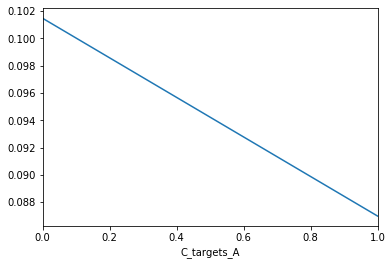

In [60]:
feats_df[feats_df['C_targets_A'] != -1].groupby('C_targets_A')['B2A_afterC'].mean().plot()

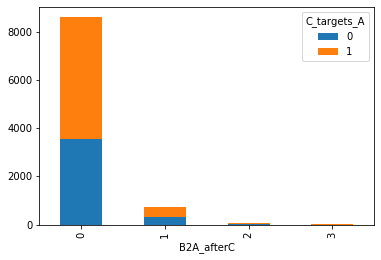

In [56]:
feats_df[feats_df['C_targets_A'] != -1].groupby('B2A_afterC')['C_targets_A'].value_counts().unstack().plot(kind='bar', stacked=True)